# Rates Simulation

Построение симуляций для моделирования поведения ключевой ставки ЦБ и ставок по кривой бескупонной доходности на различные сроки

В качестве модели будем использовать CIR

In [184]:
import random

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

from data import DATA_PATH

In [133]:
%config InlineBackend.figure_format = 'retina'

In [85]:
random.seed(42)

### Чтение данных

In [21]:
all_data = pd.read_csv(DATA_PATH / 'all_data.csv', index_col='date')
all_data.head()

,aluminum,brent,cbr_key_rate,eur_rub,moex_index,nickel,rtsi,usd_rub,su26218,su26221,...,gazp,gmkn,lkoh,magn,mgnt,moex,rosn,rual,sber,vtbr
date,,,,,,,,,,,,,,,,,,,,,
2020-01-10,1806.0,65.02,6.25,68.0555,3123.66,14116.0,1614.69,61.2340,119.766,113.450,...,251.90,198.78,6490.0,43.345,3319.5,112.99,473.50,31.700,258.19,0.047600
2020-01-13,1798.0,64.23,6.25,68.0450,3151.69,14007.5,1619.73,61.2632,119.999,113.791,...,251.50,203.62,6530.0,44.610,3345.0,114.10,481.15,32.200,262.40,0.048060
2020-01-14,1809.0,64.42,6.25,67.8162,3129.77,13781.0,1604.96,60.9474,119.800,113.597,...,250.00,200.00,6520.5,44.280,3339.0,114.02,475.50,32.830,259.05,0.047260
2020-01-15,1801.0,64.00,6.25,68.4213,3132.63,14240.0,1602.29,61.4140,119.365,113.495,...,251.30,203.96,6552.5,44.400,3440.0,115.88,474.50,32.800,256.31,0.046805
2020-01-16,1812.0,64.62,6.25,68.3747,3157.23,13700.0,1612.72,61.4328,119.402,113.360,...,254.26,209.00,6590.0,45.100,3625.0,114.50,480.95,33.575,257.51,0.047825


In [73]:
key_rates = all_data['cbr_key_rate']

In [78]:
key_rates.describe()

,cbr_key_rate
count,889.000000
mean,7.735658
std,3.397904
min,4.250000
25%,5.500000
50%,7.500000
75%,8.500000
max,20.000000


### Формальная постановка задачи

Модель CIR:

$$
d\ r_t = a(b - r_t)dt + \sigma \sqrt{r_t}dW_t
$$

- $a$ - скорость возврата к среднему значению
- $b$ - среднее значение ставки
- $r_t$ - процентная ставка в момент времени t 
- $\sigma$ - стандартное отклонение ставки (мера волатильности)
- $dW_t$ - инкремент винеровского процесса

Разностная схема: $r_{t+1} = r_t + a(b - r_t) (T_{t+1} - T_t) + \sigma \sqrt{r_t}(W_{t+1} - W_t)$

In [79]:
def cir_sim(r_0, a, b, sigma, n_days, n_sim, deltas_W=None):
    result = np.array([r_0] * n_sim).reshape(-1, 1)
    for i in range(1, n_days + 1):
        r_prev = result[:, -1].reshape(-1, 1)
        delta_t = 1
        if deltas_W is None:
            delta_W = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=(n_sim, 1))
        else:
            delta_W = deltas_W[:, i - 1].reshape(-1, 1)
        r_t_i = r_prev + a * (b - r_prev) * delta_t + sigma * np.sqrt(r_prev) * delta_W
        r_t_i = np.clip(r_t_i, 0, 100000000)
        result = np.hstack([result, r_t_i])
    return result

### Подбор параметров модели

- Параметр $\sigma$:

Волатильность можно вычислить на основе исторических данных по следующей формуле: $\sigma = std(r_t)/\sqrt{n_{days}}$, таким образом, мы сможем численно выразить волатильность для наблюдаемых ставок на каждый день в историческом периоде 

- Параметры $a$ и $b$: 

Данные параметры можно подобрать полуавтоматическим способом – путем минимизации функции ошибок (классический МНК) при симуляции данных


In [80]:
def cir_model_opt_params(params, r, dt):
    alpha, theta, sigma = params
    dw = np.random.normal(0, np.sqrt(dt))
    dr = alpha * (theta - r) * dt + sigma * np.sqrt(r) * dw
    return dr


def objective_function(params, r):
    dt = 1 / 365  # daily interval
    cum_error = 0
    for n in range(len(r)):
        cum_error += (r[n] - cir_model_opt_params(params, r[n], dt)) ** 2
    return cum_error

In [81]:
initial_params = [0.01, key_rates.mean(), (key_rates.std()) / np.sqrt(len(key_rates))]
optimal_params = minimize(objective_function, initial_params, args=(key_rates,), method='Nelder-Mead').x

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [82]:
a_opt, b_opt, sigma_opt = map(lambda p: round(p, 2), optimal_params)
print(f'{a_opt = }')
print(f'{b_opt = }')
print(f'{sigma_opt = }')

a_opt = 0.01
b_opt = 7.85
sigma_opt = 0.11


### Построим симуляции

In [124]:
def simulate(cov_matrix, n_days, n_sim, key_rate_params, risk_free_params):
    L = np.linalg.cholesky(cov_matrix)
    W_t = np.random.randn(n_sim, 2, n_days)
    W_t_corr = L @ W_t
    key_rate_sim = cir_sim(n_sim=n_sim, n_days=n_days, deltas_W=W_t_corr[:, 0], **key_rate_params)
    risk_free_sim = cir_sim(n_sim=n_sim, n_days=n_days, deltas_W=W_t_corr[:, 1], **risk_free_params)
    return key_rate_sim, risk_free_sim

In [177]:
start_date = '2021-12-01'
n_days = 100
end_date = f'{pd.Timestamp(start_date) + pd.Timedelta(days=n_days):%Y-%m-%d}'

In [178]:
sample = key_rates.loc[start_date]
target = key_rates.loc[start_date:end_date, :]

In [179]:
key_rate_params = {
    'r_0': sample,
    'a': 0.01,
    'b': 7.85,
    'sigma': 0.11,
}

risk_free_params = {
    'r_0': sample,
    'a': 0.01,
    'b': 7.85,
    'sigma': 0.11,
}

In [207]:
n_sim = 50

In [208]:
# нужно для скоррелированности симуляций
COV_MATRIX = np.cov(key_rates.T, key_rates.T)
COV_MATRIX = np.array([
    [10.0, -2.00],
    [-2.00, 20.00],
])
COV_MATRIX

array([[10., -2.],
       [-2., 20.]])

In [209]:
key_rate_sim, risk_free_sim = simulate(
    COV_MATRIX, n_days, n_sim, key_rate_params, risk_free_params
)

In [210]:
key_rate_sim.shape

(50, 101)

### Отрисуем результаты

In [211]:
def plot_simulations(simulations, target, title):
    plt.figure(figsize=(10, 5))

    plt.title(f'{title} Simulations')
    plt.xlabel('Days')
    plt.ylabel('Rate')

    for sim in simulations:
        plt.plot(sim)

    plt.plot(target, color='black', label='target')

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.grid()
    plt.legend()
    plt.show()

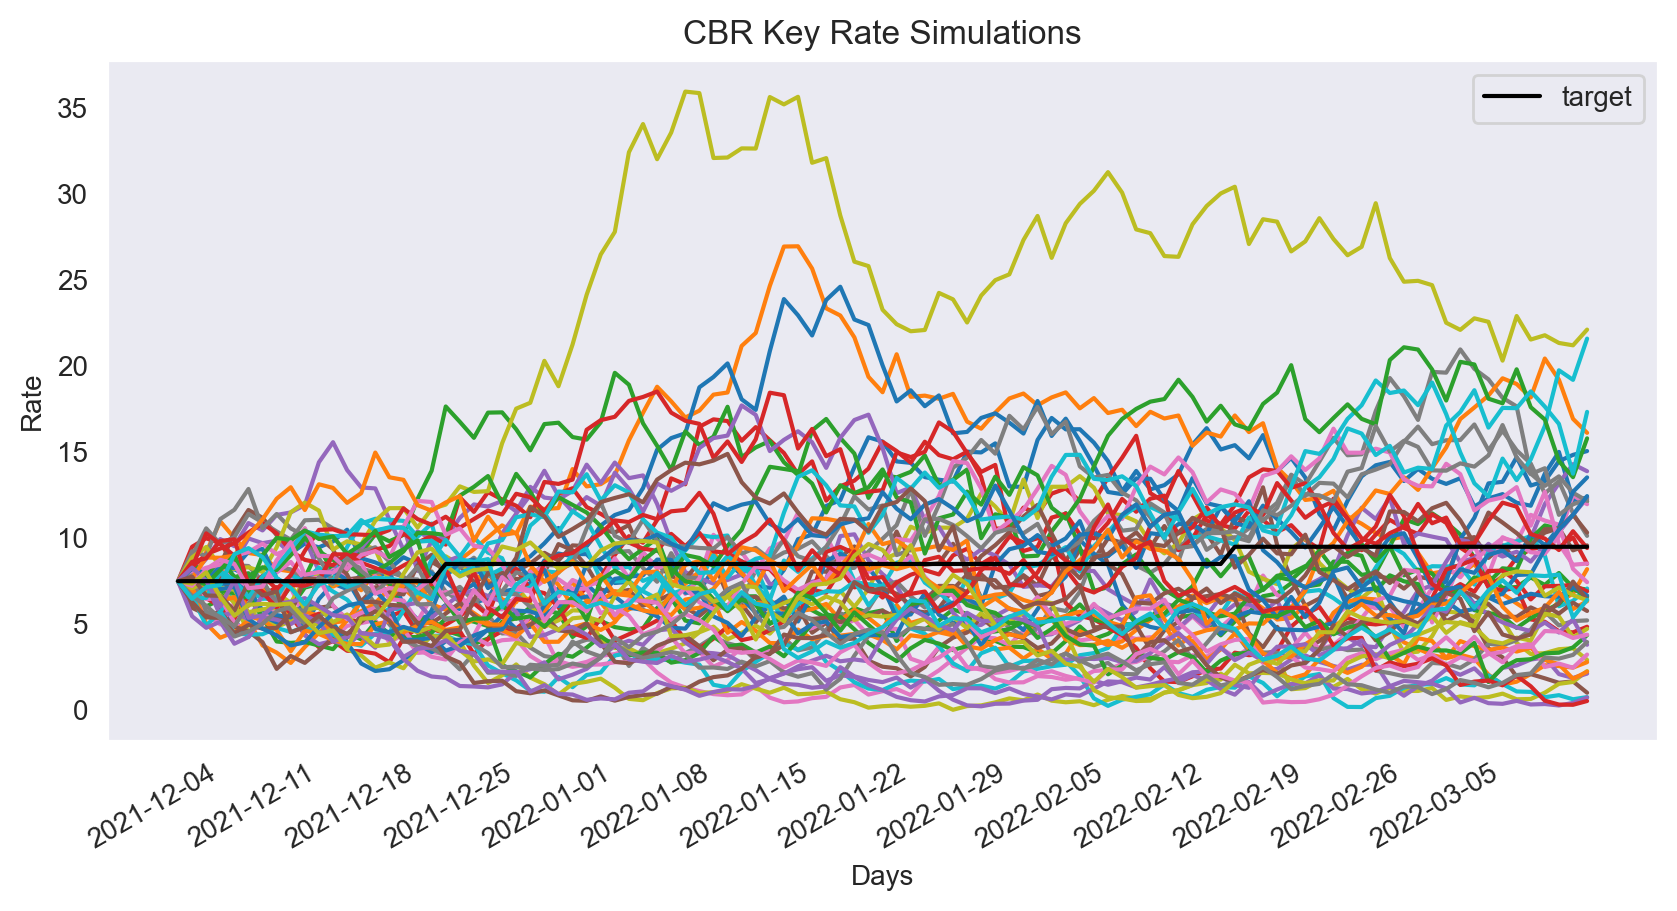

In [212]:
plot_simulations(
    key_rate_sim,
    target,
    'CBR Key Rate',
)

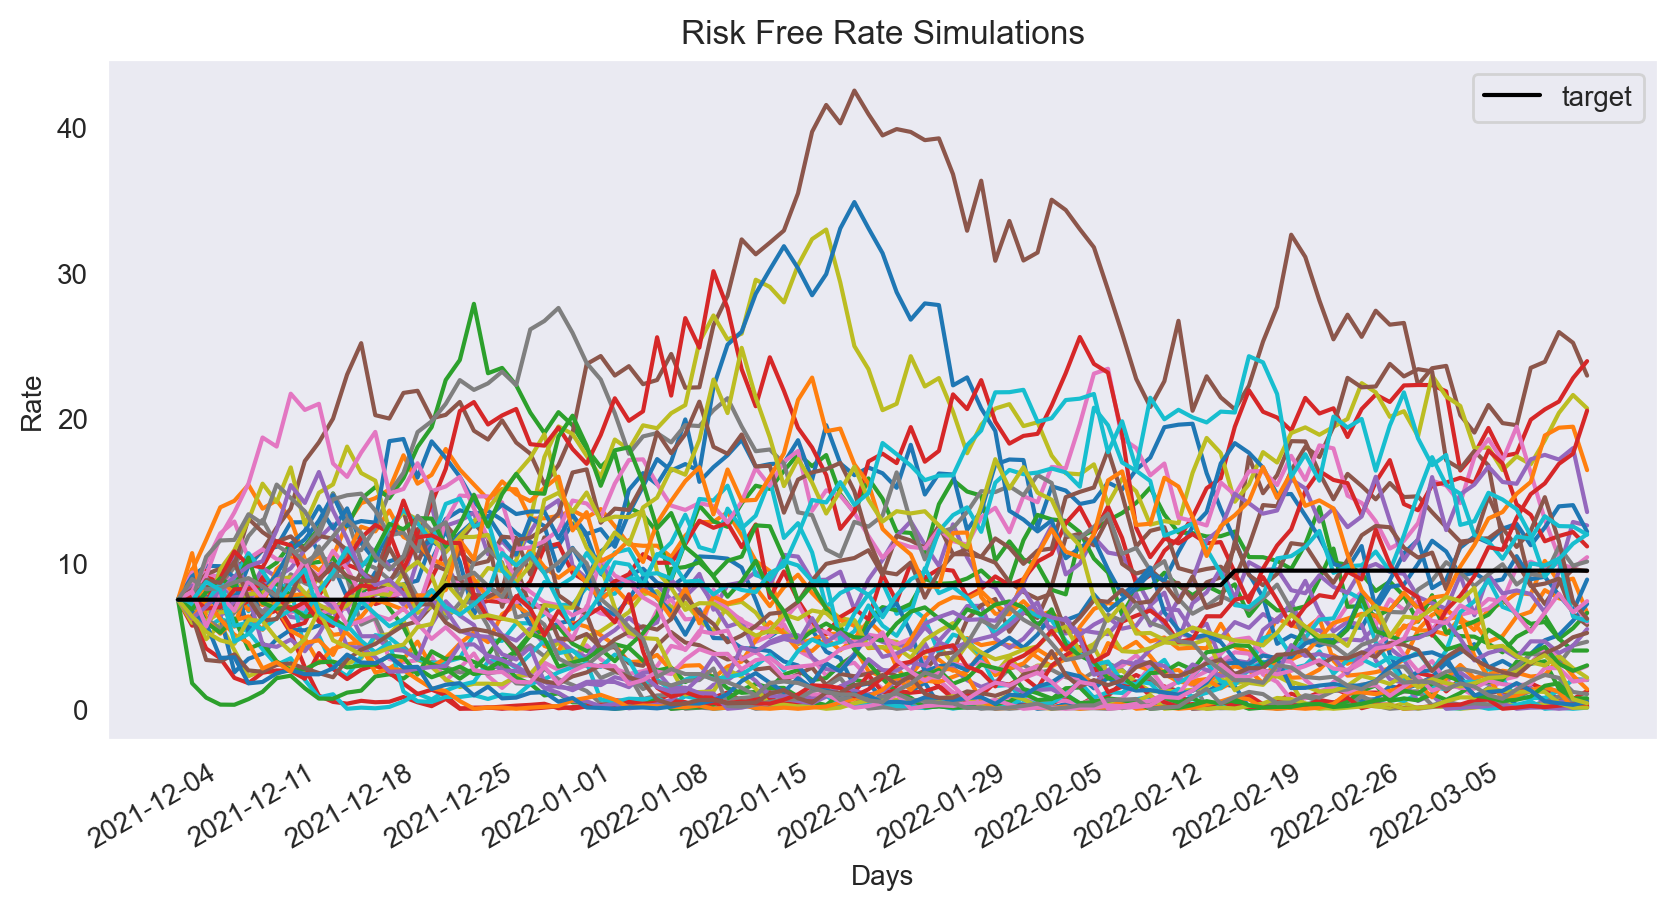

In [213]:
plot_simulations(
    risk_free_sim,
    target,
    'Risk Free Rate',
)